## Import Librarys

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
import torchvision as tv
from torchvision import transforms as T
import torchvision.transforms.functional as TF
from typing import Tuple, Dict
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

## Class for the OxfordPetsSeg Dataset that we can import from torhc.vision

In [35]:


ROOT = "./data"     # carpeta donde se descargará el dataset
IMG_SIZE = (256, 256)

# --- Transforms ---
img_tf = T.Compose([
    T.Resize(IMG_SIZE, interpolation=Image.BILINEAR),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),])

# Para visualizar, también quiero la imagen "no normalizada":
img_tf_unnorm = T.Resize(IMG_SIZE, interpolation=Image.BILINEAR)

mask_resize = T.Resize(IMG_SIZE, interpolation=Image.NEAREST)

def mask_decode_to_rgb(mask_np):
    """
    Oxford-IIIT Pet (segmentation trimaps):
      1 = fondo, 2 = borde, 3 = mascota
    Devuelve una imagen RGB colorizada para visualizar.
    """
    h, w = mask_np.shape
    rgb = np.zeros((h, w, 3), dtype=np.uint8)

    # Colores (BGR/BRG? No, usamos RGB)
    # fondo: negro, borde: amarillo, mascota: verde
    rgb[mask_np == 1] = (0, 0, 0)
    rgb[mask_np == 2] = (255, 255, 0)
    rgb[mask_np == 3] = (0, 200, 0)
    return rgb

class OxfordPetsSeg(Dataset):
    """
    Dataset para Oxford-IIIT Pet con segmentación.
    - binary=True: devuelve máscara binaria (fondo=0, {borde|mascota}=1)
    - binary=False: devuelve máscara multiclase remapeada a {0,1,2}={fondo,borde,mascota}
    Augment opcional (flip horizontal coherente imagen/máscara).
    """
    def __init__(self,
                 root: str = "./data",
                 split: str = "trainval",
                 img_size: Tuple[int,int] = (256,256),
                 binary: bool = True,
                 augment: bool = False,
                 download: bool = True):

        assert split in {"trainval", "test"}

        self.base = tv.datasets.OxfordIIITPet(
            root=root, split=split, target_types="segmentation", download=download)


        self.img_size = img_size
        self.binary = binary
        self.augment = augment

        self.img_resize = T.Resize(img_size, interpolation=Image.BILINEAR)
        self.mask_resize = T.Resize(img_size, interpolation=Image.NEAREST)
        self.to_tensor = T.ToTensor()
        self.normalize = T.Normalize(mean=[0.485,0.456,0.406],
                                     std=[0.229,0.224,0.225])

    def _process_mask(self, mask_pil: Image.Image) -> torch.Tensor:
        m = self.mask_resize(mask_pil)
        m = np.array(m, dtype=np.uint8)  # valores originales: {1=fondo, 2=borde, 3=mascota}
        if self.binary:
            m = ((m == 2) | (m == 3)).astype(np.float32)  # foreground=1
            return torch.from_numpy(m).unsqueeze(0)       # [1,H,W] para BCE/Dice binario
        else:
            # Remap a {0,1,2} -> {fondo,borde,mascota} para CrossEntropy
            remap = np.zeros_like(m, dtype=np.int64)
            remap[m == 1] = 0
            remap[m == 2] = 1
            remap[m == 3] = 2
            return torch.from_numpy(remap)                # [H,W] long

    def __len__(self): return len(self.base)

    def __getitem__(self, idx):
        img_pil, mask_pil = self.base[idx]
        img = self.img_resize(img_pil)
        mask_t = self._process_mask(mask_pil)

        # Augment simple: flip horizontal coherente
        if self.augment:
            if torch.rand(1).item() < 0.5:
                img = TF.hflip(img)
                if mask_t.ndim == 3:  # binario [1,H,W]
                    mask_t = TF.hflip(mask_t)
                else:                  # multiclase [H,W]
                    mask_t = torch.flip(mask_t, dims=[1])  # W dimension

        img = self.to_tensor(img)
        img = self.normalize(img)
        return img, mask_t

def show_images_and_masks(imgs, masks, mean=None, std=None, max_samples=6):
    """
    Visualiza pares (imagen, máscara) de un batch.

    imgs:   Tensor [B, 3, H, W]  (RGB) en [0,1] o normalizado
    masks:  Tensor [B, 1, H, W]  (binario o multiclase)
    mean, std: listas/tuplas para desnormalizar (ej. ImageNet)
    max_samples: máximo de ejemplos a mostrar
    """
    B = imgs.size(0)
    n = min(B, max_samples)

    plt.figure(figsize=(n*3, 6))

    for i in range(n):
        # --- Imagen ---
        img = imgs[i].detach().cpu().float()
        if mean is not None and std is not None:
            mean_t = torch.tensor(mean).view(3, 1, 1)
            std_t = torch.tensor(std).view(3, 1, 1)
            img = img * std_t + mean_t
        img = img.clamp(0, 1).permute(1, 2, 0).numpy()

        # --- Máscara ---
        mask = masks[i, 0].detach().cpu().numpy()

        # Imagen
        plt.subplot(2, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image {i+1}")

        # Máscara
        plt.subplot(2, n, n+i+1)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title(f"Mask {i+1}")

    plt.tight_layout()
    plt.show()



## Function for the loeaders

In [3]:
from torch.utils.data import Dataset, DataLoader, random_split

def create_pets_loaders(root: str = "./data",
                        img_size: Tuple[int,int] = (256,256),
                        batch_size: int = 8,
                        num_workers: int = 2,
                        pin_memory: bool = True,
                        binary: bool = True,
                        augment: bool = True,
                        val_split: float = 0.15,
                        seed: int = 42) -> Dict[str, DataLoader]:
    """
    Crea DataLoaders para Oxford-IIIT Pet (segmentación).

    Args:
        batch_size: tamaño del batch (puedes seleccionarlo libremente)
        binary: True -> máscara binaria; False -> multiclase {0,1,2}
        augment: flips horizontales en train
        val_split: proporción de validación sacada del split 'trainval'
    """
    # Dataset base (trainval -> lo dividimos en train/val)
    full_train = OxfordPetsSeg(root=root, split="trainval",img_size=img_size, binary=binary,
                               augment=False, download=True)

    n = len(full_train)
    n_val = int(n * val_split)
    n_train = n - n_val

    # Reproducibilidad en el split
    g = torch.Generator().manual_seed(seed)
    train_subset, val_subset = random_split(full_train, lengths=[n_train, n_val], generator=g)

    # Activar augment solo en el subset de train (envolvemos con mismo dataset pero augment=True)
    # Usamos indices del subset para acceder al dataset base con augment deseado.

    class _SubsetWithAug(Dataset):
        def __init__(self, base_ds, indices, use_augment):
            self.base = base_ds
            self.indices = indices
            self.use_augment = use_augment

        def __len__(self): return len(self.indices)


        def __getitem__(self, i):
            idx = self.indices[i]
            # toggle augment dinámicamente
            prev = self.base.augment
            self.base.augment = self.use_augment
            out = self.base[idx]
            self.base.augment = prev
            return out

    train_ds = _SubsetWithAug(full_train, train_subset.indices, use_augment=augment)
    val_ds   = _SubsetWithAug(full_train, val_subset.indices,   use_augment=False)

    # Test oficial del dataset
    test_ds = OxfordPetsSeg(root=root, split="test",
                            img_size=img_size, binary=binary,
                            augment=False, download=True)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=pin_memory, drop_last=False)

    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)

    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False,
                              num_workers=num_workers, pin_memory=pin_memory)

    return {"train": train_loader, "val": val_loader, "test": test_loader}

## Create the dataloaders

In [4]:
loaders = create_pets_loaders(
    root="./data",
    img_size=(256,256),
    batch_size=12,
    num_workers=0,
    binary=True,
    augment=True,
    val_split=0.15)

for imgs, masks in loaders["train"]:
    print(imgs.shape, masks.shape)
    break


100%|██████████| 792M/792M [00:09<00:00, 87.0MB/s]
100%|██████████| 19.2M/19.2M [00:00<00:00, 90.1MB/s]


torch.Size([12, 3, 256, 256]) torch.Size([12, 1, 256, 256])


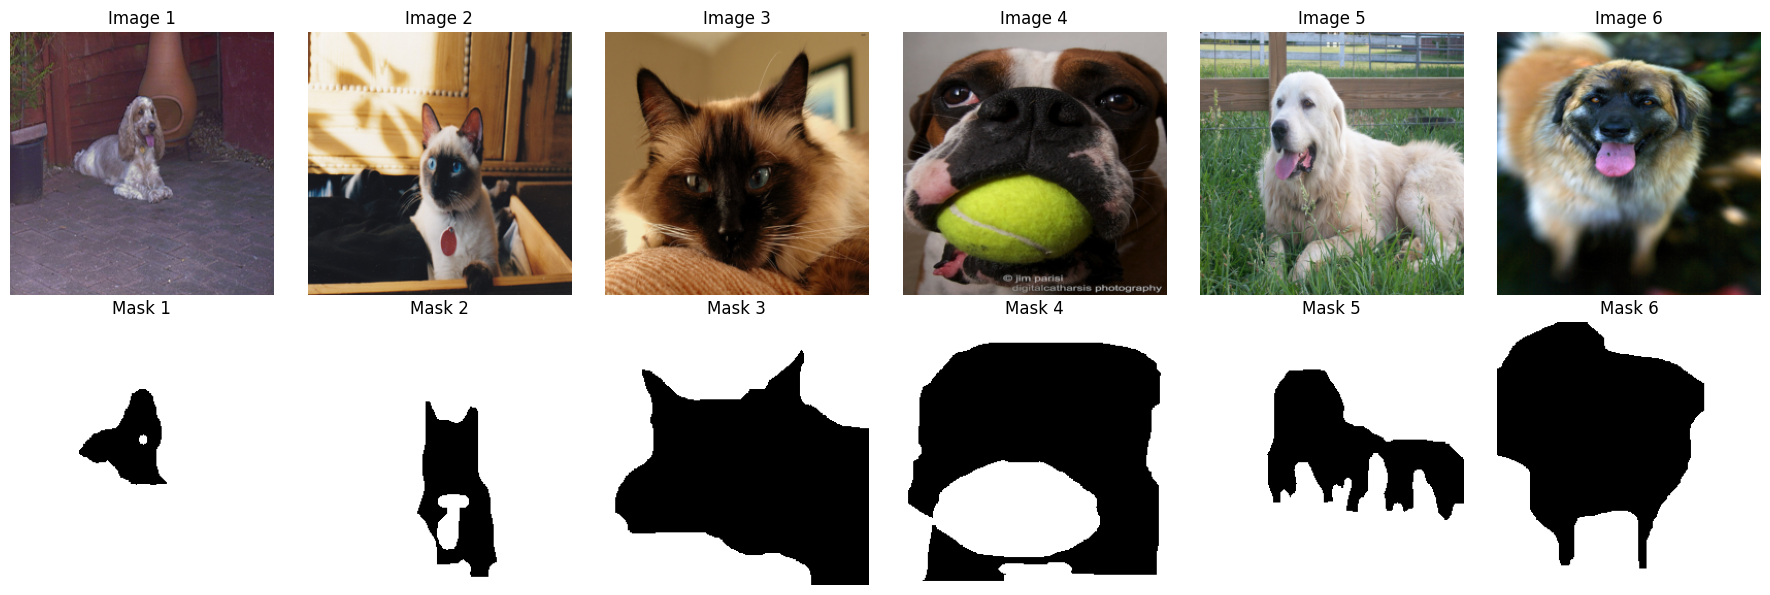

In [36]:
imgs, masks = next(iter(loaders["train"]))
show_images_and_masks(imgs, masks, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

**We are using binary masks for the y lables**

## Functions for the Model architecture

In [6]:
import torch.nn as nn

class ConvRelu(nn.Module):
    def __init__(self, in_c, out_c, k=3, s=1, p=1):
        super().__init__()

        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=True),
            nn.ReLU(inplace=True))

    def forward(self, x):
        return self.net(x)


class MaxPool(nn.Module):
    def __init__(self, k=2, s=2, p=0):
        super().__init__()
        self.net = nn.MaxPool2d(kernel_size=k, stride=s, padding=p)

    def forward(self, x):
        return self.net(x)


class UnetEncoderLayer(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = ConvRelu(in_c, out_c)
        self.conv2 = ConvRelu(out_c, out_c)
        self.pool  = MaxPool()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        skip = x
        x = self.pool(x)
        return x, skip


class UpConv(nn.Module):
    def __init__(self, in_c, out_c, k=2, s=2, p=0):
        """
        in_c: canales de entrada (del nivel más profundo)
        out_c: canales de salida después de la up-conv
        k, s, p: kernel, stride, padding (por defecto 2x2 stride=2)
        """
        super().__init__()
        self.net = nn.ConvTranspose2d(in_c, out_c, kernel_size=k, stride=s, padding=p)

    def forward(self, x):
        return self.net(x)


class UnetDecoderLayer(nn.Module):
    """
    UpConv(duplica H,W) -> Concat con skip -> Conv3x3+ReLU -> Conv3x3+ReLU
    Args:
        in_c   : canales que entran desde el nivel más profundo del decoder
        skip_c : canales del skip correspondiente del encoder
        out_c  : canales deseados a la salida del bloque
    """
    def __init__(self, in_c, skip_c, out_c):
        super().__init__()
        self.up   = UpConv(in_c, out_c)
        self.conv1 = ConvRelu(out_c + skip_c, out_c)
        self.conv2 = ConvRelu(out_c, out_c)

    def forward(self, x, skip):
        x = self.up(x)

        if x.size(-2) != skip.size(-2) or x.size(-1) != skip.size(-1):
            dh = skip.size(-2) - x.size(-2)
            dw = skip.size(-1) - x.size(-1)
            skip = skip[..., dh//2 : skip.size(-2)-(dh-dh//2),
                        dw//2 : skip.size(-1)-(dw-dw//2)]

        x = torch.cat([skip, x], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1, base=64):
        super().__init__()

        C = base
        self.enc = nn.ModuleList([
            UnetEncoderLayer(in_channels, C),   # 3 -> 64   (skip1)  H,W
            UnetEncoderLayer(C, 2*C),           # 64 -> 128 (skip2)  H/2
            UnetEncoderLayer(2*C, 4*C),         # 128->256  (skip3)  H/4
            UnetEncoderLayer(4*C, 8*C),         # 256->512  (skip4)  H/8
        ])

         # ---------- Bottleneck (doble conv) ----------
        self.bottleneck = nn.Sequential(
            ConvRelu(8*C, 16*C),                # 512 -> 1024
            ConvRelu(16*C, 16*C),               # 1024 -> 1024
        )

        # ---------- Decoder ----------
        self.dec = nn.ModuleList([
            UnetDecoderLayer(16*C, 8*C, 8*C),   # 1024 -> up -> concat skip4 (512) -> 512
            UnetDecoderLayer(8*C, 4*C, 4*C),    # 512  -> up -> concat skip3 (256) -> 256
            UnetDecoderLayer(4*C, 2*C, 2*C),    # 256  -> up -> concat skip2 (128) -> 128
            UnetDecoderLayer(2*C, C, C),        # 128  -> up -> concat skip1 (64)  -> 64
        ])

         # ---------- Salida ----------
        self.out_conv = nn.Conv2d(C, num_classes, kernel_size=1)

    def forward(self, x):
        skips = []

        # Encoder
        for layer in self.enc:
            x, skip = layer(x)
            skips.append(skip)      # [skip1, skip2, skip3, skip4]

        # Bottleneck
        x = self.bottleneck(x)
        # Decoder (usar skips en orden inverso)
        for layer, skip in zip(self.dec, reversed(skips)):
            x = layer(x, skip)
        # Logits finales

        logits = self.out_conv(x)
        return logits


## Functions for train

In [7]:
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

def _dice_coeff(pred, target, eps=1e-7):
    # pred y target binarios [B,1,H,W] en {0,1}
    inter = (pred * target).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()


def _mean_iou_mc(pred, target, num_classes, eps=1e-7):
    # multiclase: pred [B,H,W] en {0..C-1}, target idem
    ious = []
    for c in range(num_classes):
        pred_c = (pred == c)
        targ_c = (target == c)
        inter = (pred_c & targ_c).sum().float()
        union = (pred_c | targ_c).sum().float()
        if union > 0:
            ious.append(((inter + eps) / (union + eps)).item())
    return sum(ious)/len(ious) if ious else 0.0


def train_epoch_seg(dataloader, model, optimizer, criterion,num_classes=1, device=None, amp=False, desc="Train"):
    """
    Entrena 1 época un modelo de segmentación (U-Net u otro).

    Args
    ----
    dataloader: DataLoader que retorna (xb, yb)
        - xb: [B, C, H, W]
        - yb:
            * binario: [B, 1, H, W] o [B, H, W] con {0,1}
            * multiclase: [B, H, W] con enteros en [0..num_classes-1]
    model: torch.nn.Module
    optimizer: torch.optim.Optimizer
    criterion:
        * binario: nn.BCEWithLogitsLoss
        * multiclase: nn.CrossEntropyLoss
    num_classes: int
        - 1 para binario; >=2 para multiclase
    device: torch.device o str
    amp: bool -> usar mixed precision si hay CUDA disponible
    desc: str -> texto para la barra de progreso

    Returns
    -------
    dict con loss promedio, pixel accuracy y métrica (Dice o mIoU).
    """

    # --- device ---
    if device is None:
        device = next(model.parameters()).device
    elif isinstance(device, str): # Si es string ('cuda'/'cpu'), conviértelo a torch.device
        device = torch.device(device)

    use_amp = bool(amp and torch.cuda.is_available() and device.type == "cuda") # Activa AMP solo si: el usuario lo pidió, hay CUDA y el device es 'cuda'
    scaler = GradScaler(enabled=use_amp) # Crea el GradScaler (activo solo si use_amp=True)

    # --- helpers ---
    def _ensure_binary_target(y):
        # Asegura forma [B,1,H,W] y tipo float en {0,1}
        if y.dim() == 3:  # [B,H,W]
            y = y.unsqueeze(1)
        return y.float()

    def _dice_batch(pred, target, eps=1e-7):
        # pred/target: [B,1,H,W] binarios {0,1}
        inter = (pred * target).sum(dim=(1,2,3))
        sums  = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
        dice = (2 * inter + eps) / (sums + eps)  # Fórmula de Dice
        return dice.mean()  # Promedio sobre el batch

    # --- estado ---
    model.train()
    running_loss = 0.0
    running_metric = 0.0
    correct_pix = 0
    n_pix = 0
    n_samples = 0

    pbar = tqdm(dataloader, total=len(dataloader), leave=False, desc=desc)

    for xb, yb in pbar:
        xb = xb.to(device, non_blocking=True) # Sube el batch a device (GPU/CPU)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True) # Limpia gradientes (más eficiente con set_to_none=True)

        with autocast(enabled=use_amp): # Forward en precisión mixta si aplica
            logits = model(xb)   # Predicciones [B,1,H,W] (bin) o [B,C,H,W] (mc)

            if num_classes == 1:
                yb_bin = _ensure_binary_target(yb)
                loss = criterion(logits, yb_bin)   # BCEWithLogitsLoss espera float en {0,1}
            else:
                loss = criterion(logits, yb.long())    # CrossEntropyLoss: target entero [B,H,W]

        if use_amp:   # Backward + step con AMP
            scaler.scale(loss).backward()  # Escala loss para evitar underflow en gradientes FP16
            scaler.step(optimizer)
            scaler.update()  # Actualiza dinámicamente el factor de escala
        else:
            loss.backward()
            optimizer.step()  # Backprop normal en FP32

        # --- acumuladores de loss ---
        bs = xb.size(0)
        running_loss += float(loss.detach().cpu()) * bs
        n_samples += bs

        # --- métricas rápidas ---
        with torch.no_grad():    # No necesitamos gradientes para métricas
            if num_classes == 1:
                probs = torch.sigmoid(logits)      # Convierte logits a probabilidades
                pred = (probs > 0.5).float()
                yb_bin = _ensure_binary_target(yb)

                correct_pix += (pred == yb_bin).sum().item() # Píxeles correctos en el batch
                n_pix += yb_bin.numel() # Píxeles totales en el batch

                dice = _dice_batch(pred, yb_bin)        # Dice medio del batch
                running_metric += float(dice.cpu()) * bs
                metric_name = "Dice"
            else:
                pred = logits.argmax(dim=1)             # Clase más probable por píxel [B,H,W]
                correct_pix += (pred == yb).sum().item()
                n_pix       += yb.numel()

                miou = _mean_iou_mc(pred, yb, num_classes)  # debes tenerla implementada
                running_metric += float(miou) * bs # Píxeles correctos
                metric_name = "mIoU"

        # --- progreso ---
        pix_acc = 100.0 * correct_pix / max(1, n_pix) # Exactitud por píxel acumulada (%)
        pbar.set_postfix(loss=f"{running_loss/max(1,n_samples):.4f}",pix_acc=f"{pix_acc:.2f}%",**{metric_name: f"{running_metric/max(1,n_samples):.3f}"})

    # --- resumen de época ---
    epoch_loss = running_loss / max(1, n_samples) # Loss final por muestra en la época
    pix_acc = 100.0 * correct_pix / max(1, n_pix) # Pixel accuracy final
    final_metric = running_metric / max(1, n_samples) # Métrica final (Dice o mIoU)

    print(f"Train - loss: {epoch_loss:.4f} | pix_acc: {pix_acc:.2f}% | {metric_name}: {final_metric:.3f}")
    return {'loss': epoch_loss, 'pix_acc': pix_acc, metric_name: final_metric}


# --- EVAL (segmentación) ---
def evaluate_seg(dataloader, model, criterion,
                 num_classes=1, device=None, amp=True, desc="Val"):
    """
    Evalúa 1 época (sin gradientes). Reporta loss promedio por muestra,
    pixel accuracy y Dice (binario) o mIoU (multiclase).
    """
    # --- device ---
    if device is None:
        device = next(model.parameters()).device
    elif isinstance(device, str):
        device = torch.device(device)

    use_amp = bool(amp and torch.cuda.is_available() and device.type == "cuda")

    def _ensure_binary_target(y):
        if y.dim() == 3:  # [B,H,W] -> [B,1,H,W]
            y = y.unsqueeze(1)
        return y.float()

    def _dice_batch(pred, target, eps=1e-7):
        inter = (pred * target).sum(dim=(1,2,3))
        sums  = pred.sum(dim=(1,2,3)) + target.sum(dim=(1,2,3))
        return ((2*inter + eps) / (sums + eps)).mean()

    model.eval()
    running_loss = 0.0
    running_metric = 0.0
    correct_pix = 0
    n_pix = 0
    n_samples = 0

    pbar = tqdm(dataloader, total=len(dataloader), leave=False, desc=desc)

    with torch.no_grad():
        for xb, yb in pbar:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True)

            with autocast(enabled=use_amp):
                logits = model(xb)
                if num_classes == 1:
                    yb_bin = _ensure_binary_target(yb)
                    loss = criterion(logits, yb_bin)
                else:
                    loss = criterion(logits, yb.long())

            bs = xb.size(0)
            running_loss += float(loss.detach().cpu()) * bs
            n_samples += bs

            if num_classes == 1:
                probs = torch.sigmoid(logits)            # [B,1,H,W]
                pred  = (probs > 0.5).float()
                yb_bin = _ensure_binary_target(yb)

                correct_pix += (pred == yb_bin).sum().item()
                n_pix       += yb_bin.numel()

                dice = _dice_batch(pred, yb_bin)
                running_metric += float(dice.cpu()) * bs
                metric_name = "Dice"
            else:
                pred = logits.argmax(dim=1)              # [B,H,W]
                correct_pix += (pred == yb).sum().item()
                n_pix       += yb.numel()

                miou = _mean_iou_mc(pred, yb, num_classes)
                running_metric += float(miou) * bs
                metric_name = "mIoU"

            # Postfix estable
            avg_loss = running_loss / max(1, n_samples)
            pix_acc  = 100.0 * correct_pix / max(1, n_pix)
            avg_met  = running_metric / max(1, n_samples)
            pbar.set_postfix(loss=f"{avg_loss:.4f}",pix_acc=f"{pix_acc:.2f}%",**{metric_name: f"{avg_met:.3f}"})

    epoch_loss = running_loss / max(1, n_samples)
    pix_acc    = 100.0 * correct_pix / max(1, n_pix)
    final_metric = running_metric / max(1, n_samples)
    print(f"Val   - loss: {epoch_loss:.4f} | pix_acc: {pix_acc:.2f}% | {metric_name}: {final_metric:.3f}")
    return {'loss': epoch_loss, 'pix_acc': pix_acc, metric_name: final_metric}


## Create the model

In [8]:
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=3, num_classes=1).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()


## Train the model on the data set

In [9]:
epochs = 10

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    train_metrics = train_epoch_seg(loaders['train'], model, opt, criterion, num_classes=1, device=device, amp=True)
    val_metrics = evaluate_seg(loaders['val'], model, criterion, num_classes=1, device=device)


/tmp/ipython-input-3622621910.py:59: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=use_amp) # Crea el GradScaler (activo solo si use_amp=True)



Epoch 1/10


Train:   0%|          | 0/261 [00:00<?, ?it/s]/tmp/ipython-input-3622621910.py:91: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp): # Forward en precisión mixta si aplica


Train - loss: 0.5995 | pix_acc: 69.65% | Dice: 0.806


Val:   0%|          | 0/46 [00:00<?, ?it/s]/tmp/ipython-input-3622621910.py:187: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=use_amp):


Val   - loss: 0.5590 | pix_acc: 70.74% | Dice: 0.819

Epoch 2/10


Train - loss: 0.4897 | pix_acc: 74.94% | Dice: 0.817


Val   - loss: 0.4389 | pix_acc: 78.97% | Dice: 0.842

Epoch 3/10


Train - loss: 0.4447 | pix_acc: 78.73% | Dice: 0.842


Val   - loss: 0.4173 | pix_acc: 80.52% | Dice: 0.859

Epoch 4/10


Train - loss: 0.4297 | pix_acc: 79.71% | Dice: 0.850


Val   - loss: 0.4090 | pix_acc: 80.87% | Dice: 0.862

Epoch 5/10


Train - loss: 0.4226 | pix_acc: 80.09% | Dice: 0.852


Val   - loss: 0.4042 | pix_acc: 81.32% | Dice: 0.863

Epoch 6/10


Train - loss: 0.4120 | pix_acc: 80.79% | Dice: 0.857


Val   - loss: 0.3985 | pix_acc: 81.59% | Dice: 0.860

Epoch 7/10


Train - loss: 0.3945 | pix_acc: 82.02% | Dice: 0.865


Val   - loss: 0.3708 | pix_acc: 83.11% | Dice: 0.871

Epoch 8/10


Train - loss: 0.3663 | pix_acc: 83.58% | Dice: 0.874


Val   - loss: 0.3409 | pix_acc: 84.98% | Dice: 0.887

Epoch 9/10


Train - loss: 0.3421 | pix_acc: 84.86% | Dice: 0.882


Val   - loss: 0.3534 | pix_acc: 84.18% | Dice: 0.886

Epoch 10/10


Train - loss: 0.3286 | pix_acc: 85.48% | Dice: 0.887


Val   - loss: 0.3408 | pix_acc: 84.98% | Dice: 0.891


***

### Segmentation Performance Evaluation

We evaluated the model's segmentation performance using per-pixel probability maps and an error overlay visualization. The left panel shows the input image, the middle panel overlays the predicted probability map (after sigmoid activation) onto the image, and the right panel highlights the classification outcomes:

- **Green (TP)** – Correctly segmented regions.
- **Red (FP)** – Background pixels incorrectly predicted as foreground.
- **Blue (FN)** – Foreground pixels missed by the model.

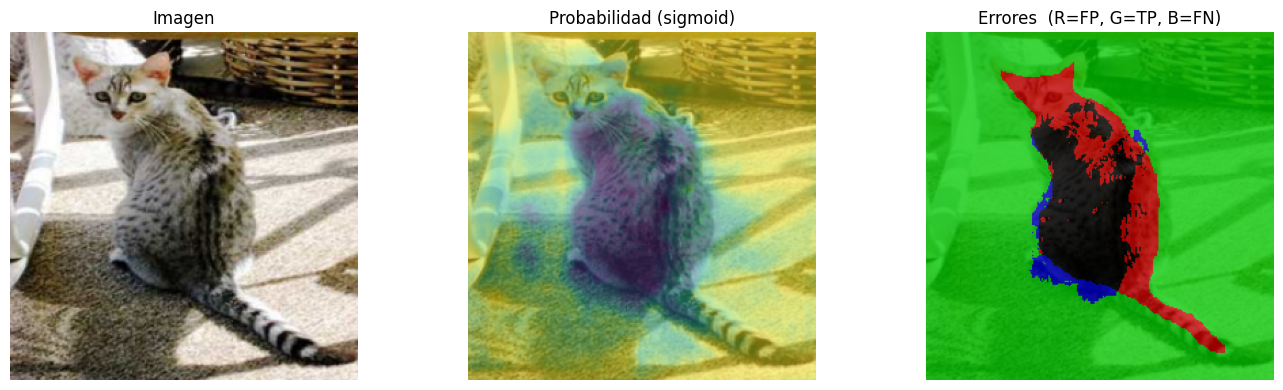

In [34]:
import numpy as np, torch, matplotlib.pyplot as plt
from scipy import ndimage as ndi

def unnormalize_img_1(x_chw, mean, std):
    """
    x_chw: tensor [C,H,W] normalizado
    mean,std: tu normalización por canal (tuplas/listas de len C)
    return: np.float32 en [0,1]
    """
    x = x_chw.detach().cpu().float().clone()
    for c in range(x.size(0)):
        x[c] = x[c] * std[c] + mean[c]
    x = x.clamp(0, 1)
    return x.permute(1,2,0).numpy()

def get_logits(out):
    """Convierte la salida del modelo a un Tensor de logits."""
    if isinstance(out, (tuple, list)):
        return out[0]
    if isinstance(out, dict):
        return out.get('out', next(iter(out.values())))
    return out

def clear_all_hooks(module):
    # borra hooks de este módulo
    if hasattr(module, "_forward_hooks"):       module._forward_hooks.clear()
    if hasattr(module, "_forward_pre_hooks"):   module._forward_pre_hooks.clear()
    if hasattr(module, "_backward_hooks"):      module._backward_hooks.clear()
    # recursivo
    for m in module.children():
        clear_all_hooks(m)

clear_all_hooks(model)

def viz_overlay_errors(xb, out_or_logits, yb, thr=0.5, mean=None, std=None, titles=True):
    """
    Visualiza imagen, mapa de probabilidad y mapa de errores (R=FP, G=TP, B=FN).

    xb:  [1,C,H,W]
    out_or_logits: Tensor logits [1,1,H,W] o salida cruda del modelo (tuple/dict/Tensor)
    yb:  [1,1,H,W] o [1,H,W] con {0,1}
    thr: umbral de probabilidad para binarizar (binario)
    mean/std: tu normalización (p.ej. ImageNet) para desnormalizar la imagen
    """
    assert xb.size(0) == 1, "Pasa batch de tamaño 1 para visualizar"
    x = xb[0]

    # Imagen a [H,W,3] en [0,1]
    if mean is not None and std is not None:
        img = unnormalize_img_1(x, mean, std)
    else:
        img = x.detach().cpu().permute(1,2,0).float().numpy()
        # si C=1, replicamos canales para mostrar en RGB
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)
        vmin, vmax = img.min(), img.max()
        img = (img - vmin) / (vmax - vmin + 1e-8)
    img = np.clip(img, 0, 1)

    # Logits -> probas
    logits = get_logits(out_or_logits)
    prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()

    # Ground truth a [H,W] uint8
    y = yb[0]
    if y.dim() == 3:   # [1,H,W] -> [H,W]
        y = y[0]
    gt = y.detach().cpu().numpy().astype(np.uint8)

    # Predicción binaria
    pred = (prob > thr).astype(np.uint8)

    # Contornos (opcional)
    edge_pred = np.logical_xor(pred, ndi.binary_erosion(pred))
    edge_gt   = np.logical_xor(gt,   ndi.binary_erosion(gt))

    # Mapa de errores RGB
    err = np.zeros((*pred.shape, 3), dtype=float)
    err[...,0] = (pred == 1) & (gt == 0)   # FP → rojo
    err[...,1] = (pred == 1) & (gt == 1)   # TP → verde
    err[...,2] = (pred == 0) & (gt == 1)   # FN → azul

    # Plots
    plt.figure(figsize=(14,4))
    ax = plt.subplot(1,3,1); ax.imshow(img); ax.axis('off')
    if titles: ax.set_title("Imagen")

    ax = plt.subplot(1,3,2); ax.imshow(img); ax.imshow(prob, alpha=0.5); ax.axis('off')
    if titles: ax.set_title("Probabilidad (sigmoid)")

    ax = plt.subplot(1,3,3); ax.imshow(img*0.6); ax.imshow(err, alpha=0.6); ax.axis('off')
    if titles: ax.set_title("Errores  (R=FP, G=TP, B=FN)")
    plt.tight_layout(); plt.show()


model.eval()
with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb1, yb1 = xb[:1].to(device), yb[:1].to(device)
    out = model(xb1)

imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std  = (0.229, 0.224, 0.225)

viz_overlay_errors(xb1, out, yb1, thr=0.5, mean=imagenet_mean, std=imagenet_std)


The results show that the model successfully captures the main object shape and boundaries, with most of the cat's body correctly segmented (green). However, there are some false positives along the background edges and a few false negatives around fine details, such as the tail tip and body contour. These errors suggest the model is generally accurate but could benefit from improved handling of thin structures and background-foreground transitions.

***

### Precision–Recall and ROC Curve Analysis

We also evaluated the model’s pixel-wise classification performance using the `plot_pr_roc_from_logits` function.  
This function takes the raw model logits and ground truth masks, computes per-pixel probabilities via the sigmoid function,  
and then calculates and plots the following metrics:

- **Precision–Recall (PR) Curve:** Shows the trade-off between precision and recall across thresholds.  
- **Average Precision (AP):** 0.969 in this evaluation, indicating consistently high precision even at high recall.  
- **Receiver Operating Characteristic (ROC) Curve:** Plots the true positive rate (TPR) vs. false positive rate (FPR).  
- **Area Under the ROC Curve (AUC):** 0.928, reflecting strong separability between positive (foreground) and negative (background) pixels.


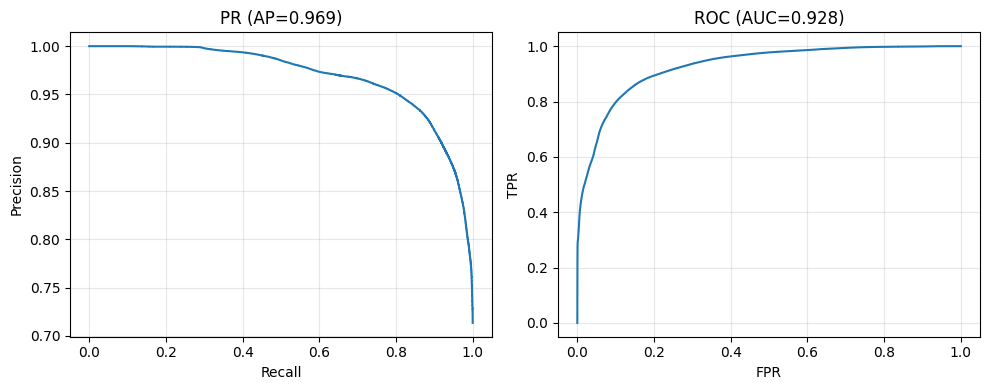

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc

def plot_pr_roc_from_logits(logits, yb, mask_valid=None):
    """
    logits: [B,1,H,W], yb: [B,1,H,W] o [B,H,W] {0,1}
    mask_valid: opcional [B,H,W] o [B,1,H,W] (True donde evaluar)
    """
    probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
    y = yb.detach().cpu()
    if y.dim()==3: y = y.unsqueeze(1)
    y = y.numpy().reshape(-1)

    if mask_valid is not None:
        m = mask_valid
        if isinstance(m, torch.Tensor): m = m.detach().cpu().numpy()
        m = m.reshape(-1).astype(bool)
        probs, y = probs[m], y[m]

    p, r, _ = precision_recall_curve(y, probs)
    ap = average_precision_score(y, probs)
    fpr, tpr, _ = roc_curve(y, probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(r, p); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR (AP={ap:.3f})"); plt.grid(True, alpha=.3)
    plt.subplot(1,2,2); plt.plot(fpr, tpr); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC (AUC={roc_auc:.3f})"); plt.grid(True, alpha=.3)
    plt.tight_layout(); plt.show()

model.eval()
with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb, yb = xb.to(device), yb.to(device)
    logits = model(xb)
plot_pr_roc_from_logits(logits, yb)


These metrics provide a threshold-independent view of model performance and complement segmentation-specific scores (such as Dice or IoU),  
allowing for a more complete understanding of the model’s discriminative ability.

***

### Image-level Overlap Metrics (Dice & IoU)

We computed **per-image Dice and IoU** from raw model logits using two utility functions:

- `dice_per_image_from_logits(logits, yb, thr=0.5)`: applies a sigmoid to logits, binarizes predictions at threshold `thr`, and returns a Dice score **per image** in the batch.
- `iou_per_image_from_logits(logits, yb, thr=0.5)`: same pipeline, returning IoU **per image**.
- Both functions accept masks as `[B,1,H,W]` or `[B,H,W]` and use a small `eps` for numerical stability.

The helper `plot_hist_metrics(dices, ious)` visualizes the distribution of scores across the dataset.


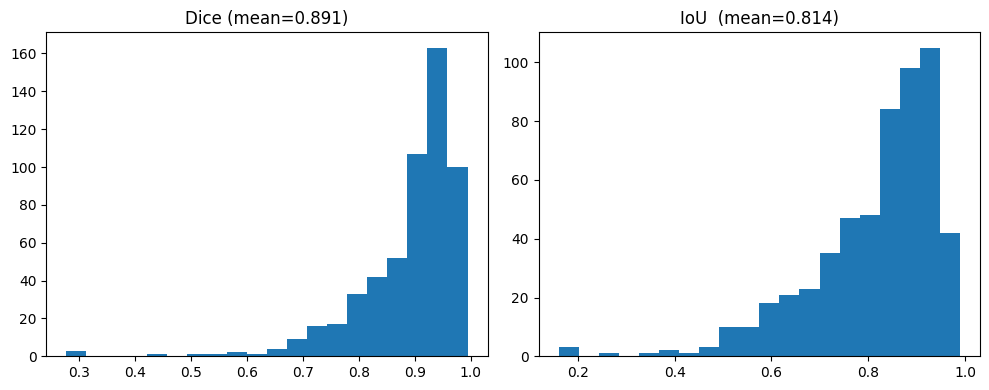

In [12]:
def dice_per_image_from_logits(logits, yb, thr=0.5, eps=1e-7):
    """
    retorna lista de Dice por imagen
    """
    probs = torch.sigmoid(logits)
    if yb.dim()==3: yb = yb.unsqueeze(1)
    y = yb.float()
    pred = (probs > thr).float()

    inter = (pred*y).sum(dim=(1,2,3))
    sums = pred.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3))
    dice = (2*inter + eps)/(sums + eps)                 # [B]
    return dice.detach().cpu().numpy()

def iou_per_image_from_logits(logits, yb, thr=0.5, eps=1e-7):
    probs = torch.sigmoid(logits)
    if yb.dim()==3: yb = yb.unsqueeze(1)
    y = yb.float()
    pred = (probs > thr).float()
    inter = (pred*y).sum(dim=(1,2,3))
    union = pred.sum(dim=(1,2,3)) + y.sum(dim=(1,2,3)) - inter
    iou = (inter + eps)/(union + eps)
    return iou.detach().cpu().numpy()

def plot_hist_metrics(dices, ious):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.hist(dices, bins=20); plt.title(f"Dice (mean={np.mean(dices):.3f})")
    plt.subplot(1,2,2); plt.hist(ious,  bins=20); plt.title(f"IoU  (mean={np.mean(ious):.3f})")
    plt.tight_layout(); plt.show()


model.eval()
all_dice, all_iou = [], []
with torch.no_grad():
    for xb, yb in loaders['val']:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        all_dice.extend(dice_per_image_from_logits(logits, yb))
        all_iou.extend(iou_per_image_from_logits(logits, yb))
plot_hist_metrics(np.array(all_dice), np.array(all_iou))


**Current results (threshold = 0.5):**
- **Mean Dice:** 0.891  
- **Mean IoU:** 0.814  
- Histograms are **right-skewed**, indicating most images achieve high overlap, with a small tail of harder cases.

**Interpretation & notes:**
- Dice ≈ 0.89 suggests strong region overlap; IoU ≈ 0.81 is consistent with that level of performance.
- Low-scoring outliers likely correspond to thin structures/boundaries or atypical backgrounds; inspecting these helps guide error analysis.
- Since these metrics depend on the binarization threshold, we keep `thr=0.5` fixed for reporting; threshold tuning (e.g., maximizing Dice on a val set) can further refine performance.

*** 

### Pixel-level Calibration Analysis

We assess how well predicted probabilities reflect true frequencies using the `calibration_curve_pixels` function.  
This function converts logits to probabilities with a sigmoid, bins pixels into `n_bins` equal-width bins over `[0,1]`, and, for each bin, plots:
- **Mean predicted confidence** (x-axis)
- **Empirical positive rate** (y-axis)

The dashed diagonal is perfect calibration (`confidence = accuracy`). Points **below** the diagonal indicate **overconfidence** (predicted probabilities are too high), and points **above** indicate **underconfidence**.

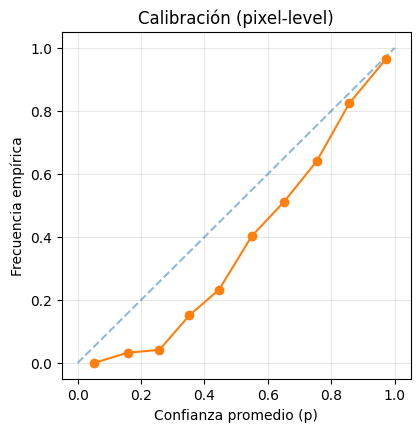

In [13]:
def calibration_curve_pixels(logits, yb, n_bins=10):
    probs = torch.sigmoid(logits).detach().cpu().numpy().reshape(-1)
    y = yb.detach().cpu()
    if y.dim()==3: y = y.unsqueeze(1)
    y = y.numpy().reshape(-1)

    bins = np.linspace(0,1,n_bins+1)
    binids = np.digitize(probs, bins)-1
    conf, acc = [], []
    for b in range(n_bins):
        m = (binids==b)
        if m.sum()==0:
            conf.append(np.nan); acc.append(np.nan)
        else:
            conf.append(probs[m].mean())
            acc.append(y[m].mean())
    conf, acc = np.array(conf), np.array(acc)
    plt.figure(figsize=(4.5,4.5))
    plt.plot([0,1],[0,1],'--',alpha=.5)
    plt.plot(conf, acc, marker='o')
    plt.xlabel("Confianza promedio (p)"); plt.ylabel("Frecuencia empírica")
    plt.title("Calibración (pixel-level)"); plt.grid(True, alpha=.3); plt.show()


with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb, yb = xb.to(device), yb.to(device)
    logits = model(xb)
calibration_curve_pixels(logits, yb)

**Observed behavior (this run):**
- The curve is **below the diagonal** for low–mid confidences (~0.2–0.6) → the model is **overconfident** in that range.
- Around ~0.8, it slightly crosses **above** the diagonal (mild **underconfidence**).
- Near 1.0, it approaches the diagonal (close to perfectly calibrated at high confidence).

**Usage note:** This is a pixel-wise analysis for binary segmentation; it complements overlap metrics (Dice/IoU) by checking the **probabilistic reliability** of the model. If needed, temperature scaling or Platt/Isotonic calibration can be applied on a validation set to reduce miscalibration (e.g., minimizing ECE) before final reporting.

*** 

### Convolutional Feature Map Visualization

We inspected the internal representations learned by the model by visualizing the output of a selected convolutional layer using a forward hook.  
The visualization displays **12 feature maps** from a `Conv2d` layer, each highlighting different spatial patterns and textures detected by the network.

**Purpose of the function:**  
The feature map visualization function registers a forward hook on a chosen layer, captures its activation output during a forward pass, and displays a subset of channels (feature maps) after normalizing them to the [0,1] range for display.

Encontré estas capas: ['conv1.net.0', 'conv2.net.0']


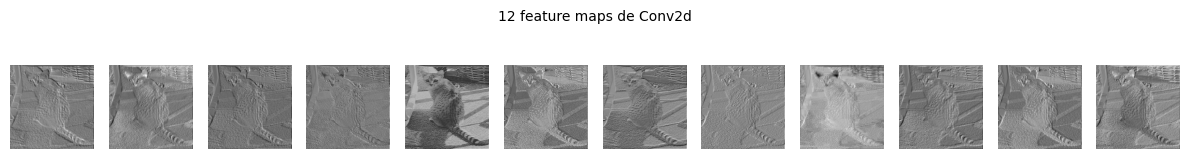

In [27]:

def _first_tensor(o):
    if isinstance(o, torch.Tensor):
        return o
    if isinstance(o, (list, tuple)):
        for v in o:
            t = _first_tensor(v)
            if t is not None:
                return t
    if isinstance(o, dict):
        for v in o.values():
            t = _first_tensor(v)
            if t is not None:
                return t
    return None

def visualize_feature_maps(model, layer, xb, num_maps=16):
    activ = {}

    def hook_fn(m, i, o):
        # toma el primer Tensor que encuentre en o (soporta tuple/list/dict)
        import torch
        def first_tensor(x):
            if isinstance(x, torch.Tensor): return x
            if isinstance(x, (list, tuple)):
                for v in x:
                    t = first_tensor(v)
                    if t is not None: return t
            if isinstance(x, dict):
                for v in x.values():
                    t = first_tensor(v)
                    if t is not None: return t
            return None

        t = first_tensor(o)
        if t is None:
            raise TypeError(f"No pude extraer un Tensor de la salida de {m.__class__.__name__}. Tipo={type(o)}")
        activ['maps'] = t.detach().cpu()

    handle = layer.register_forward_hook(hook_fn)

    was_training = model.training
    try:
        model.eval()
        xb = xb.to(next(model.parameters()).device, non_blocking=True)
        with torch.no_grad():
            _ = model(xb)
    finally:
        handle.remove()
        if was_training: model.train()

    maps = activ['maps']
    if maps.ndim == 4: maps = maps[0]      # [C,H,W]
    elif maps.ndim == 3: pass
    elif maps.ndim == 2: maps = maps.unsqueeze(0)
    else: raise ValueError(f"Dim no soportada: {maps.shape}")

    import matplotlib.pyplot as plt
    n = min(num_maps, maps.size(0))
    plt.figure(figsize=(n, 1.6))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        fmap = maps[i]; mn, mx = fmap.min(), fmap.max()
        fmap = (fmap - mn) / (mx - mn + 1e-6)
        ax.imshow(fmap, cmap='gray'); ax.axis('off')
    plt.suptitle(f"{n} feature maps de {layer.__class__.__name__}", y=1.02, fontsize=10)
    plt.tight_layout(); plt.show()

def pick_layer(block, kind=nn.Conv2d, idx=0):
    """
    Retorna la subcapa número idx de tipo `kind` dentro de `block`.
    También imprime los nombres encontrados para que puedas elegir.
    """
    found = [(n, m) for n, m in block.named_modules() if isinstance(m, kind)]
    if not found:
        raise ValueError(f"No se encontró ninguna subcapa de tipo {kind} en {block.__class__.__name__}")
    print("Encontré estas capas:", [n for n, _ in found])
    return found[idx][1]

clear_all_hooks(model)
xb, _ = next(iter(loaders['val']))
xb1 = xb[:1].to(device)
# ejemplo: una capa concreta de tu modelo
layer = pick_layer(model.enc[0], nn.Conv2d, idx=0)
visualize_feature_maps(model, layer=layer, xb=xb1, num_maps=12)


**Insights from this example:**
- Several maps emphasize **edges and contours** of the cat and background structures.
- Some channels capture **fine textures** (e.g., fur patterns, surface details), while others respond to **larger structural regions**.
- The diversity in activation patterns suggests the layer is learning a mix of **low- to mid-level visual features** that will be further processed in deeper layers.

This type of analysis is useful for understanding **what the model focuses on** at different depths, diagnosing potential biases, and guiding architectural or training adjustments.

*** 

### Bottleneck Representation Analysis (UMAP/t-SNE)

We probe the model’s **latent space** by extracting activations at the bottleneck layer and projecting them to 2D with UMAP/t-SNE.

**What the functions do**
- `collect_bottleneck(model, loader, hook_layer)`: registers a forward hook on the selected bottleneck module, collects its activations over the dataset, flattens them to `[N, D]`, and (optionally) returns labels `Y` if provided by the loader.
- `plot_embedding_2d(X, Y=None, method="umap", n=5000)`: reduces the first `n` vectors in `X` to 2D (UMAP if available, else t-SNE) and plots them; if `Y` is given, points are color-coded by class.

**What we are evaluating**
- **Geometry of the latent space**: whether samples form coherent clusters or exhibit clear margins, which reflects the model’s ability to learn **class-separable** or **structure-aware** features before decoding.


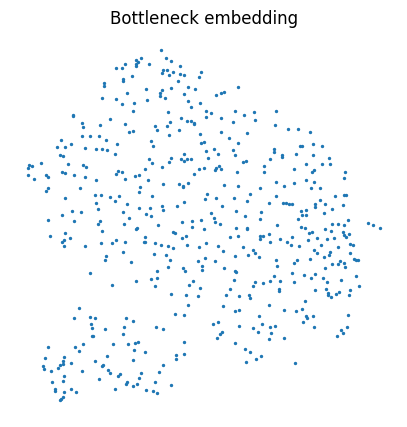

In [28]:
from sklearn.manifold import TSNE
try:
    import umap
    HAVE_UMAP = True
except:
    HAVE_UMAP = False

def collect_bottleneck(model, loader, device, hook_layer):
    """
    hook_layer: módulo en el bottleneck
    retorna: X [N, D] flattened, y opcional si loader lo provee
    """
    feats = []
    ys = []
    def hook_fn(m,i,o):
        feats.append(o.detach().cpu())
    h = hook_layer.register_forward_hook(hook_fn)

    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            _ = model(xb)
            if isinstance(yb, torch.Tensor):
                ys.append(yb.clone())
    h.remove()
    X = torch.cat([f.flatten(1) for f in feats], dim=0).numpy()
    Y = torch.cat(ys, dim=0).numpy() if ys else None
    return X, Y

def plot_embedding_2d(X, Y=None, method="umap", n=5000, title="Bottleneck embedding"):
    Xs = X[:n]
    if method=="umap" and HAVE_UMAP:
        reducer = umap.UMAP(n_components=2)
        Z = reducer.fit_transform(Xs)
    else:
        Z = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(Xs)
    plt.figure(figsize=(5,5))
    if Y is None:
        plt.scatter(Z[:,0], Z[:,1], s=2)
    else:
        y = Y[:n].reshape(-1)
        sc = plt.scatter(Z[:,0], Z[:,1], c=y, s=2, cmap='tab10')
        plt.colorbar(sc, fraction=0.046)
    plt.title(title); plt.axis('off'); plt.show()


hook_layer = model.bottleneck if hasattr(model, "bottleneck") else list(model.modules())[-2]
X, Y = collect_bottleneck(model, loaders['val'], device, hook_layer)
plot_embedding_2d(X, Y=None, method="umap")

**Observed behavior (this run)**
- The embedding shows a **diffuse cloud** with mild local groupings but **no sharply separated clusters**. This suggests the bottleneck captures useful continuous variations, yet global separability is limited in this projection.

**How to use this insight**
- If labels exist, re-plot with `Y` to assess **class separation** (e.g., boundary vs. background).
- Quantify structure with **k-NN purity**, **Silhouette score**, or **Linear Probe** accuracy on `X`.
- If separation is weak, consider stronger supervision/regularization at the bottleneck (e.g., contrastive loss, auxiliary heads) or increasing capacity/context (dilations, attention).

*** 

### Boundary Quality Metrics (Boundary-F1 and Hausdorff Distance)

We evaluate **edge fidelity** of the predicted masks using two boundary-focused metrics:

- **Boundary-F1 (with pixel tolerance):**  
  We compute binary boundary maps for prediction and ground truth, apply a symmetric dilation with tolerance `±2 px`, and measure precision/recall of boundary hits. The F1 summarizes alignment of predicted and true edges while being robust to small pixel shifts.

- **Symmetric Hausdorff Distance (on boundaries):**  
  We extract boundary points and compute the maximum of the two directed Hausdorff distances. This captures the **worst-case** boundary deviation (in pixels) between prediction and ground truth.

In [29]:
from scipy.spatial.distance import directed_hausdorff

def boundary_map(mask):
    mask = mask.astype(bool)
    return np.logical_xor(mask, ndi.binary_erosion(mask))

def boundary_f1(pred, gt, tol=2):
    """
    F1 sobre bordes con tolerancia en pixeles (afín a BFScore).
    pred, gt: binarios [H,W]
    """
    bp = boundary_map(pred); bg = boundary_map(gt)
    # dilatación para tolerancia
    se = ndi.generate_binary_structure(2,1)
    dp = ndi.binary_dilation(bp, structure=se, iterations=tol)
    dg = ndi.binary_dilation(bg, structure=se, iterations=tol)

    tp_p = (bp & dg).sum();  tp_g = (bg & dp).sum()
    p = bp.sum();            r = bg.sum()
    prec = tp_p / (p + 1e-7); rec = tp_g / (r + 1e-7)
    f1 = 2*prec*rec/(prec+rec+1e-7)
    return f1, prec, rec

def hausdorff_distance(pred, gt):
    """ Hausdorff simétrico aproximado (usa puntos de borde). """
    bp = np.argwhere(boundary_map(pred))
    bg = np.argwhere(boundary_map(gt))
    if len(bp)==0 or len(bg)==0:
        return np.nan
    d1 = directed_hausdorff(bp, bg)[0]
    d2 = directed_hausdorff(bg, bp)[0]
    return max(d1, d2)



with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
    xb1, yb1 = xb[:1].to(device), yb[:1].to(device)
    logits = model(xb1)
prob = torch.sigmoid(logits)[0,0].cpu().numpy()
pred = (prob>0.5).astype(np.uint8)

gt = yb1[0]
if gt.dim()==3: gt = gt[0]
gt = gt.cpu().numpy().astype(np.uint8)

bf1, bprec, brec = boundary_f1(pred, gt, tol=2)
hd = hausdorff_distance(pred, gt)
print("Boundary-F1:", bf1, "Hausdorff:", hd)

Boundary-F1: 0.6027826915546971 Hausdorff: 49.678969393496885


**Current results**
- **Boundary-F1 (tol=2 px):** **0.603**  
  → Moderate edge alignment: many contours are captured, but there are noticeable misses or small offsets—especially on thin structures and high-curvature regions.
- **Hausdorff distance:** **49.68 px**  
  → There exist localized regions with large boundary gaps (outliers), indicating occasional over/under-segmentation or broken contours.

**Interpretation & next steps**
- The mask overlaps (Dice/IoU) are strong, but boundary metrics reveal **edge brittleness**.  
- To improve: increase boundary awareness via loss terms (e.g., Dice+Boundary loss, Laplacian/level-set losses), add high-resolution skip connections or dilated convolutions, refine post-processing (CRF/graph cut/thinning), and augment data with **edge-focused** transformations (small shifts, elastic, thin-structure emphasis).

*** 

### Occlusion Sensitivity Analysis (ΔDice)

We assessed the **spatial importance** of different image regions for the segmentation model using an occlusion sensitivity test.  
The method systematically replaces small patches of the input with a neutral value and measures the resulting **drop in Dice score (ΔDice)** compared to the unoccluded prediction.

**What the function does:**
1. Runs the model on the original image to obtain a baseline Dice score against the ground truth mask.
2. Iteratively occludes patches (`patch` size, `stride` configurable) by replacing them with a neutral fill value.
3. Recomputes the prediction and Dice score after each occlusion.
4. Stores the Dice drop in a **heatmap**, where higher values indicate greater importance of that region for accurate segmentation.

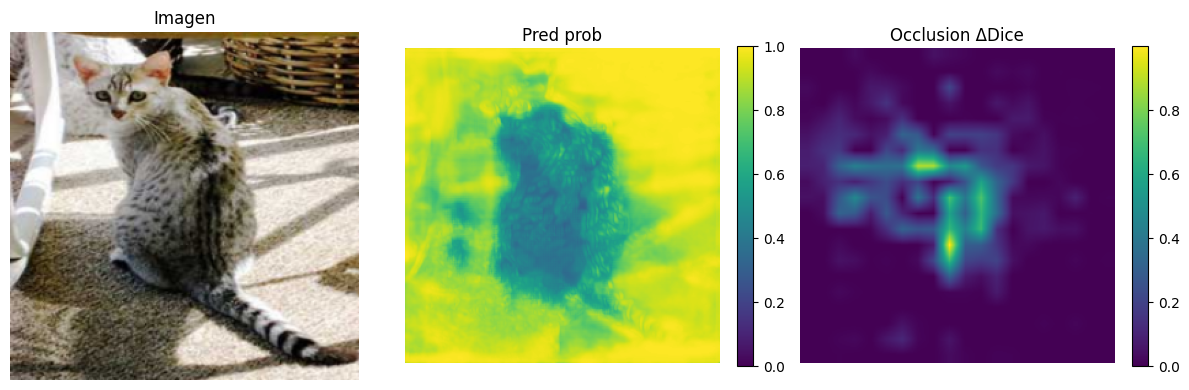

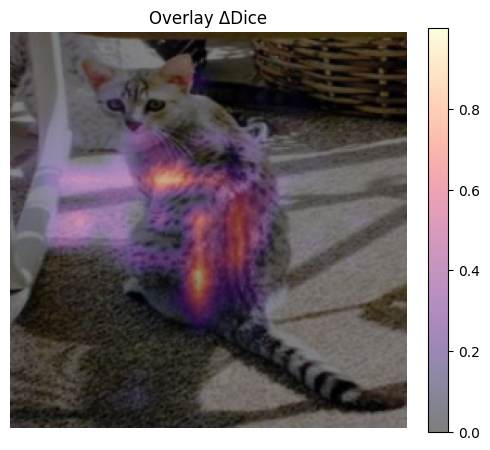

In [32]:
import torch.nn.functional as F

def unnormalize_img(x, mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225)):
    """
    x: Tensor [3,H,W] normalizado -> retorna np.ndarray [H,W,3] en [0,1]
    Ajusta mean/std a lo que usaste en tus transforms.
    """
    x = x.detach().cpu().clone()
    for c in range(min(3, x.shape[0])):
        x[c] = x[c]*std[c] + mean[c]
    x = x.clamp(0,1).permute(1,2,0).numpy()
    return x

@torch.no_grad()
def occlusion_sensitivity(
    model, xb, yb, patch=24, stride=12, thr=0.5, device='cuda',
    mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225), overlay=True):

    """
    Devuelve heatmap (H,W) con la caída de Dice al ocluir parches.
    Superpone el heatmap sobre la imagen des-normalizada para visualizar.
    """

    assert xb.size(0) == 1
    model.eval()
    xb = xb.to(device)
    yb = yb.to(device).float()
    if yb.dim() == 3: yb = yb.unsqueeze(1)  # [1,1,H,W]
    H, W = xb.shape[-2:]

    # --- Predicción base y Dice base ---
    base_logits = model(xb)
    base_prob   = torch.sigmoid(base_logits)[0,0]            # [H,W]
    base_pred   = (base_prob > thr).float()
    inter       = (base_pred * yb[0,0]).sum()
    denom       = base_pred.sum() + yb[0,0].sum()
    eps = 1e-7
    base_dice   = (2*inter + eps) / (denom + eps)

    rows = list(range(0, H - patch + 1, stride))
    cols = list(range(0, W - patch + 1, stride))
    heat_coarse = torch.zeros(1, 1, len(rows), len(cols), device=device)

    # Relleno por canal: media de la propia imagen (mejor que poner 0)
    fill = xb.mean(dim=(-1,-2), keepdim=True)   # [1,C,1,1]

    for ri, i in enumerate(rows):
        for cj, j in enumerate(cols):
            xb_occ = xb.clone()
            xb_occ[..., i:i+patch, j:j+patch] = fill  # oclusión "natural"
            p = torch.sigmoid(model(xb_occ))[0,0]
            pred = (p > thr).float()
            inter = (pred * yb[0,0]).sum()
            denom = pred.sum() + yb[0,0].sum()
            dice  = (2*inter + eps) / (denom + eps)
            drop  = torch.clamp(base_dice - dice, min=0.0)
            heat_coarse[0,0,ri,cj] = drop

    # --- Interpolar a resolución completa para visualización suave ---
    heat = F.interpolate(
        heat_coarse, size=(H, W), mode='bilinear', align_corners=False)[0,0].detach().cpu().numpy()

    # Normalizar heat para colorbar agradable
    if heat.max() > 0:
        heat_vis = heat / (heat.max() + 1e-8)
    else:
        heat_vis = heat

    # --- Visualización ---
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1); plt.title("Imagen")
    img = unnormalize_img(xb[0], mean=mean, std=std)
    plt.imshow(img); plt.axis('off')

    plt.subplot(1,3,2); plt.title("Pred prob")
    plt.imshow(base_prob.detach().cpu(), vmin=0, vmax=1)
    plt.axis('off'); plt.colorbar(fraction=0.046)

    # Heatmap puro
    plt.subplot(1,3,3); plt.title("Occlusion ΔDice")
    plt.imshow(heat_vis)
    plt.axis('off'); plt.colorbar(fraction=0.046)

    plt.tight_layout(); plt.show()

    # Overlay opcional (útil para reportes)
    if overlay:
        plt.figure(figsize=(5,5))
        plt.title("Overlay ΔDice")
        plt.imshow(img)
        plt.imshow(heat_vis, alpha=0.5, cmap='magma')
        plt.axis('off'); plt.colorbar(fraction=0.046)
        plt.tight_layout(); plt.show()

    return heat


with torch.no_grad():
    xb, yb = next(iter(loaders['val']))
heat = occlusion_sensitivity(model, xb[:1], yb[:1], patch=24, stride=12, device=device)

**Observed behavior (this run):**
- The heatmap highlights the **torso and upper body** of the cat as the most influential regions for the model’s segmentation decision.
- Background regions show near-zero ΔDice, confirming they have little effect on the output.
- The overlay visualization confirms that the **highest-sensitivity zones** align with the object’s structural core, where precise boundary placement is critical.

**Interpretation:**
- The model’s reliance is concentrated on central object features, suggesting it uses **texture and shape cues** from the main body rather than relying heavily on peripheral or background context.
- Occlusion sensitivity is complementary to saliency or Grad-CAM maps, providing a **quantitative, metric-driven** measure of feature importance tied directly to segmentation accuracy.